In [ ]:
# import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from IPython.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn import tree
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [63]:
sub = pd.read_csv('data/sample_submission.csv')
sub.head(3)

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100


![metric](https://imgur.com/B3gwVf8.jpg)

## What to Predict
1. Predict the FVC, Forced Vital [Lung] Capacity
2. The Confidence column is the standard deviation of FVC

## How the scoring works
1. The competition will be scored where only the data with 70 percentile confidence/standard deviation will be evaluated
2. If the FVC number is off by more than 1000, it will be penalized less (log(sqrt(2*standard deviation)))
3. The average metric across 3 different weeks per patient for every patient will generate a final score. 
4. It will be negative, the higher the number, the better

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [3]:
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('FVC', axis='columns')
y = df['FVC']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.47872326936005016

In [4]:
# Tutorial from: https://github.com/LambdaSchool/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/module3-quantile-regression/LS_DS_233_Quantile_Regression.ipynb

# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# Also, these formulas break with . in variable name, so lets change that

# Now let's construct the formula string using all columns
quant_formula = 'FVC ~ ' + ' + '.join(df.drop('FVC', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
quant_reg.summary()  # "summary" is another very R-thing

FVC ~ Weeks + Percent + Age


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    FVC   Pseudo R-squared:               0.3438
Model:                       QuantReg   Bandwidth:                       181.2
Method:                 Least Squares   Sparsity:                        833.6
Date:                Mon, 03 Aug 2020   No. Observations:                 1549
Time:                        12:38:37   Df Residuals:                     1545
                                        Df Model:                            3
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1303.0025    108.336     12.027      0.000    1090.501    1515.504
Weeks         -1.4935      0.456     -3.272      0.001      -2.389      -0.598
Percent       32.8807      0.537     61.246      0.000      31.828      33.934
Age          -14.4928      1.511     -9.594      0.000     -17.456     -11.530
==============================================================================

The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
# Tutorial from: https://github.com/LambdaSchool/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/module3-quantile-regression/LS_DS_233_Quantile_Regression.ipynb

quantiles = (.05, .96, .1)

for quantile in quantiles:
    print(quant_mod.fit(q=quantile).summary())

                         QuantReg Regression Results                          
Dep. Variable:                    FVC   Pseudo R-squared:               0.1271
Model:                       QuantReg   Bandwidth:                       217.7
Method:                 Least Squares   Sparsity:                        3532.
Date:                Mon, 03 Aug 2020   No. Observations:                 1549
Time:                        12:44:09   Df Residuals:                     1545
                                        Df Model:                            3
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1290.6976    215.543      5.988      0.000     867.909    1713.486
Weeks          1.3577      0.849      1.599      0.110      -0.308       3.024
Percent       14.5237      1.182     12.288      0.000      12.205      16.842
Age          -13.6244      2.670     -5.102      0.0

In [7]:
# Tutorial from: https://github.com/LambdaSchool/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/module3-quantile-regression/LS_DS_233_Quantile_Regression.ipynb

# multicollinearity - maybe we shouldn't throw every variable in our formula. 
quant_formula = 'FVC ~ Weeks + Percent + Age'
quant_mod = smf.quantreg(quant_formula, data=df)
for quantile in range(50, 100):
    quantile /= 100
    quant_reg = quant_mod.fit(q=quantile)
    print((quantile, quant_reg.prsquared))

(0.5, 0.34377689858131477)
(0.51, 0.34889696862906583)
(0.52, 0.3536951685582135)
(0.53, 0.3583515792715152)
(0.54, 0.3628582749589825)
(0.55, 0.3671495043363533)
(0.56, 0.3711925645127211)
(0.57, 0.37515257537105373)
(0.58, 0.3791061979418928)
(0.59, 0.38314062124454806)
(0.6, 0.3871987910796666)
(0.61, 0.3913397993131864)
(0.62, 0.3954923038576541)
(0.63, 0.3996917900126338)
(0.64, 0.40388603435229964)
(0.65, 0.40809467237153396)
(0.66, 0.4122169641828193)
(0.67, 0.4163131679178951)
(0.68, 0.4206402077948205)
(0.69, 0.4251210490112036)
(0.7, 0.430200594471038)
(0.71, 0.43533051923428234)
(0.72, 0.44064325125574544)
(0.73, 0.44589500954551253)
(0.74, 0.4512904091319069)
(0.75, 0.4565098976044496)
(0.76, 0.46155288799897853)
(0.77, 0.4664511562609165)
(0.78, 0.4712355695751377)
(0.79, 0.4760734359620289)
(0.8, 0.4811513116500178)
(0.81, 0.486280339563824)
(0.82, 0.49292585937774147)
(0.83, 0.49962935665287633)
(0.84, 0.5062844050986264)
(0.85, 0.5129759827250315)
(0.86, 0.5195945373984

In [13]:
# ==============================================================================
# ==============================================================================
# ==============================================================================

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    FVC   Pseudo R-squared:               0.6452
Model:                       QuantReg   Bandwidth:                       247.7
Method:                 Least Squares   Sparsity:                        7552.
Date:                Mon, 03 Aug 2020   No. Observations:                 1549
Time:                        20:42:52   Df Residuals:                     1545
                                        Df Model:                            3
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2447.4686    137.339     17.821      0.000    2178.078    2716.859
Weeks         -1.3029      0.866     -1.505      0.133      -3.001       0.396
Percent       42.1985      0.878     48.078      0.000      40.477      43.920
Age          -30.3325      2.641    -11.485      0.000     -35.513     -25.152
==============================================================================

The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# Tutorial from: https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html

import statsmodels.api as sm

data = sm.datasets.engel.load_pandas().data
data.head()

,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


In [10]:
# Tutorial from: https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html

mod = smf.quantreg('foodexp ~ income', data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Mon, 03 Aug 2020   No. Observations:                  235
Time:                        12:46:26   Df Residuals:                      233
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000      52.649     110.315
income         0.5602      0.013     42.516      0.000       0.534       0.586

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


In [11]:
# Tutorial from: https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html

# For convenience, we place the quantile regression results in a Pandas DataFrame, and the OLS results in a dictionary.

quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['income']] + \
            res.conf_int().loc['income'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

ols = smf.ols('foodexp ~ income', data).fit()
ols_ci = ols.conf_int().loc['income'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['income'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

      q           a         b        lb        ub
0  0.05  124.880095  0.343361  0.268632  0.418090
1  0.15  111.693660  0.423708  0.382780  0.464636
2  0.25   95.483539  0.474103  0.439900  0.508306
3  0.35  105.841294  0.488901  0.457759  0.520043
4  0.45   81.083647  0.552428  0.525021  0.579835
5  0.55   89.661370  0.565601  0.540955  0.590247
6  0.65   74.033435  0.604576  0.582169  0.626982
7  0.75   62.396584  0.644014  0.622411  0.665617
8  0.85   52.272216  0.677603  0.657383  0.697823
9  0.95   64.103964  0.709069  0.687831  0.730306
{'a': 147.47538852370573, 'b': 0.48517842367692354, 'lb': 0.4568738130184233, 'ub': 0.5134830343354237}


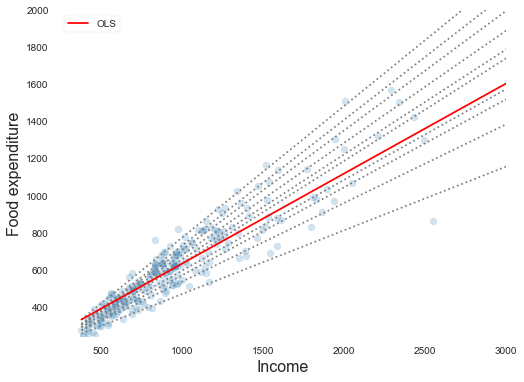

In [12]:
# Tutorial from: https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html

x = np.arange(data.income.min(), data.income.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')

y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(data.income, data.foodexp, alpha=.2)
ax.set_xlim((240, 3000))
ax.set_ylim((240, 2000))
legend = ax.legend()
ax.set_xlabel('Income', fontsize=16)
ax.set_ylabel('Food expenditure', fontsize=16);

In [14]:
# ==============================================================================
# ==============================================================================
# ==============================================================================

#  Creating log-Laplace continuous random variable

from scipy.stats import loglaplace 
	
numargs = loglaplace.numargs 
a, b = 4.32, 3.18
rv = loglaplace(a, b) 
	
print ("RV : \n", rv) 


RV : 


In [15]:
# tutorial from: https://www.geeksforgeeks.org/python-log-laplace-distribution-in-statistics/

#  log-Laplace continuous variates and probability distribution
import numpy as np  
quantile = np.arange (0.01, 1, 0.1)  
  
# Random Variates  
R = loglaplace.rvs(a, b)  
print ("Random Variates : \n", R)  
  
# PDF  
R = loglaplace.pdf(a, b, quantile)  
print ("\nProbability Distribution : \n", R)  

Random Variates : 
 3.85887864929731

Probability Distribution : 
 [0.00354227 0.00390749 0.00432054 0.0047891  0.00532229 0.00593104
 0.00662848 0.00743048 0.00835629 0.00942939]


Distribution : 
 [0.         0.06122449 0.12244898 0.18367347 0.24489796 0.30612245
 0.36734694 0.42857143 0.48979592 0.55102041 0.6122449  0.67346939
 0.73469388 0.79591837 0.85714286 0.91836735 0.97959184 1.04081633
 1.10204082 1.16326531 1.2244898  1.28571429 1.34693878 1.40816327
 1.46938776 1.53061224 1.59183673 1.65306122 1.71428571 1.7755102
 1.83673469 1.89795918 1.95918367 2.02040816 2.08163265 2.14285714
 2.20408163 2.26530612 2.32653061 2.3877551  2.44897959 2.51020408
 2.57142857 2.63265306 2.69387755 2.75510204 2.81632653 2.87755102
 2.93877551 3.        ]


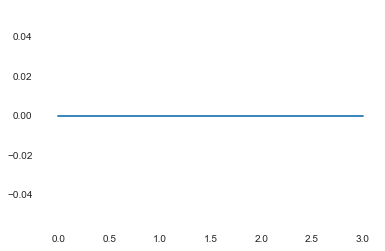

In [16]:
# tutorial from: https://www.geeksforgeeks.org/python-log-laplace-distribution-in-statistics/

# Graphical Representation.

import numpy as np  
import matplotlib.pyplot as plt  
     
distribution = np.linspace(0, np.minimum(rv.dist.b, 3))  
print("Distribution : \n", distribution)  
     
plot = plt.plot(distribution, rv.pdf(distribution))  

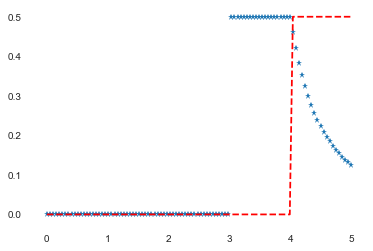

In [17]:
# tutorial from: https://www.geeksforgeeks.org/python-log-laplace-distribution-in-statistics/

import matplotlib.pyplot as plt  
import numpy as np  
     
x = np.linspace(0, 5, 100)  
     
# Varying positional arguments  
y1 = loglaplace .pdf(x, 1, 3)  
y2 = loglaplace .pdf(x, 1, 4)  
plt.plot(x, y1, "*", x, y2, "r--")  


<AxesSubplot:xlabel='x', ylabel='y1'>

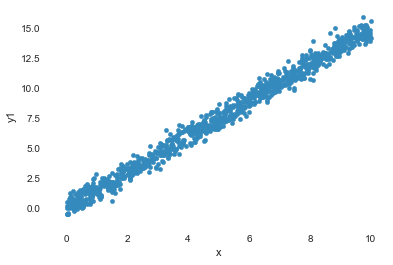

In [18]:
# ==============================================================================
# ==============================================================================
# ==============================================================================

# tutorial from: https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d

import numpy as np
import pandas as pd
N, m, s1, s2, xmax = 1000, 1.5, 0.5, 2.0, 10
x = np.random.uniform(0,xmax,N)
e1 = np.random.normal(0,s1,N)
e2 = np.random.normal(0,s2,N)
y1 = m*x + e1
y2 = m*x + e2
data = pd.DataFrame({'x': x, 'y1': y1, 'y2': y2})
data.plot(x='x', y='y1', kind='scatter')

<AxesSubplot:xlabel='x', ylabel='y2'>

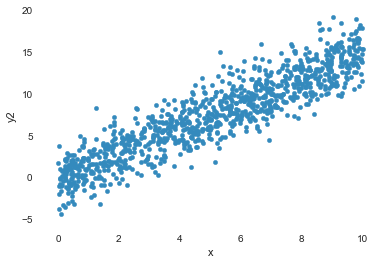

In [19]:
# tutorial from: https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d

data.plot(x='x', y='y2', kind='scatter')

In [21]:
# tutorial from: https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d

from scipy.optimize import minimize
def square_deviation_y1(p):
    return np.sum( (y1 - p[0]*x - p[1])**2 )
def square_deviation_y2(p):
    return np.sum( (y2 - p[0]*x - p[1])**2 )
m1, b1 = minimize(square_deviation_y1, [0,0]).x
m2, b2 = minimize(square_deviation_y2, [0,0]).x

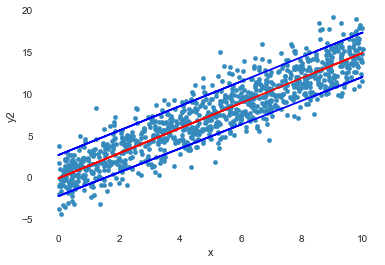

In [39]:
# tutorial from: https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d

def quantile_loss_y1(q):
    def quantile_deviation(p):
        z = y1 - p[0]*x - p[1]
        return np.sum(np.where(z < 0, z * (q-1), z * q))
    return quantile_deviation
def quantile_loss_y2(q):
    def quantile_deviation(p):
        z = y2 - p[0]*x - p[1]
        return np.sum(np.where(z < 0, z * (q-1), z * q))
    return quantile_deviation
m1_q10, b1_q10 = minimize(quantile_loss_y1(0.10), [1.5,0]).x
m1_q90, b1_q90 = minimize(quantile_loss_y1(0.90), [1.5,0]).x
m2_q10, b2_q10 = minimize(quantile_loss_y2(0.10), [1.5,0]).x
m2_q90, b2_q90 = minimize(quantile_loss_y2(0.90), [1.5,0]).x
#y1
(m1_q10, b1_q10) = (1.48, -0.55)
(m1_q90, b1_q90) = (1.51, 0.56)
#y2
(m2_q10, b2_q10) = (1.43, -2.24)
(m2_q90, b2_q90) = (1.47, 2.68)

x = np.random.uniform(0,xmax,N)
data.plot(x='x', y='y2', kind='scatter')
plt.plot(x, m2* x + b2, color = 'r')
plt.plot(x, m2_q10* x + b2_q10, color = 'b')
plt.plot(x, m2_q90* x + b2_q90, color = 'b')

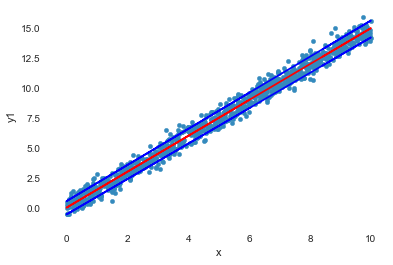

In [40]:
# tutorial from: https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d

data.plot(x='x', y='y1', kind='scatter')
plt.plot(x, m1* x + b1, color = 'r')
plt.plot(x, m1_q10* x + b1_q10, color = 'b')
plt.plot(x, m1_q90* x + b1_q90, color = 'b')

In [41]:
# tutorial from: https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d

#  I only want to over-estimate a wine’s quality 10% of the time. 

df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')
from sklearn.model_selection import train_test_split
X, y = df.drop(['quality'], axis=1), df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
from sklearn.ensemble import GradientBoostingRegressor
def train_model(quantile):
    params = {
        'n_estimators': 2000,
        'max_depth': 6,
        'min_samples_split': 5,
        'learning_rate': 0.01,
        'loss': 'quantile',
        'alpha': quantile,
        'random_state': 42
     }
    regressor = GradientBoostingRegressor(**params)
    return regressor.fit(X_train, y_train)
model = train_model(0.1) # this might take a little while
results = pd.DataFrame({'y_predicted': model.predict(X_test), 'y_true': y_test})
results.head()

,y_predicted,y_true
2312,5.000000,5
1634,5.000000,6
3220,4.875596,5
1837,5.027104,7
680,4.994433,5


In [43]:
# tutorial from: https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d

true_lt_predicted = (results['y_true'] < results['y_predicted']).astype(int)
(true_lt_predicted.sum() * 1.0)/true_lt_predicted.count()

def test_quantile(model):
    results = pd.DataFrame({'y_predicted': model.predict(X_test), 'y_true': y_test})
    true_lt_predicted = (results['y_true'] < results['y_predicted']).astype(int)
    return (true_lt_predicted.sum()*1.0)/true_lt_predicted.count() 
quantile_pairs = []
# it will take a few minutes to train all of these models maybe grab another coffee while this runs :)
for q in np.linspace(0.05,0.95,19):
    model = train_model(q)
    pq = test_quantile(model)
    quantile_pairs.append((q, pq))

In [45]:
# tutorial from: https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d

(true_lt_predicted.sum() * 1.0)/true_lt_predicted.count()
# I will over-estimate the quality of the wine 9.3% of the time

0.09387755102040816

(0.0, 1.5)

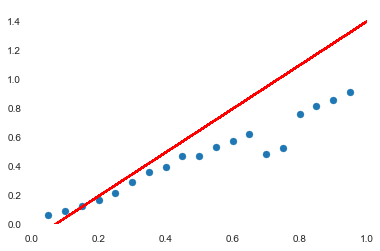

In [62]:
# tutorial from: https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d

# plot quantile pairs
x = []
y = []
for i in quantile_pairs:
    xs = i[0]
    ys = i[1]
    x.append(xs)
    y.append(ys)
plt.scatter(x,y)

x = np.random.uniform(0,xmax,N)
plt.plot(x, m2* x + b2, color = 'r')
plt.xlim(0,1)
plt.ylim(0,1.5)

In [47]:
# tutorial from: https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d

np.linspace(0.05,0.95,19)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])